# 210126 Create test database

In [1]:
from pathlib import Path
import json
from string import ascii_uppercase

In [2]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

In [4]:
from midas.kmers import KmerSpec, find_kmers, vec_to_coords
from midas.cython.metrics import jaccard_coords
from midas.io.signaturefile import SignatureFile
from midas.db.models import Genome, ReferenceGenomeSet, AnnotatedGenome, Taxon
from midas.db.migrate import init_db

In [5]:
DATESTR = '210126'
DATESTR_LONG = '2021-01-26'
EXPTNAME = DATESTR + '-artificial-test-database'

DBNAME = 'testdb_' + DATESTR

## File paths

In [6]:
outdir = Path('output')
outdir.mkdir(exist_ok=True)

In [7]:
tmpdir = Path('tmp')
tmpdir.mkdir(exist_ok=True)

## Funcs

In [8]:
NUC_BYTES = np.fromiter(map(ord, 'ACGT'), dtype=np.uint8)

In [9]:
def array2seq(a):
    return Seq(a.tobytes().decode())

In [10]:
def mutate_seq(a, n):
    """Randomly mutate sequence array in-place at n positions."""
    for i in np.random.choice(range(len(a)), n, replace=False):
        a[i] = np.random.choice(NUC_BYTES)

In [11]:
def make_mutations(a, m, n):
    """Make m mutated versions of an array a, each with n mutated positions."""
    for i in range(m):
        ma = a.copy()
        mutate_seq(ma, n)
        yield ma

In [12]:
def pw_dists(sigs):
    n = len(sigs)
    out = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i):
            out[i, j] = out[j, i] = 1 - jaccard_coords(sigs[i], sigs[j])
    
    return out

In [13]:
def array_signature(kspec, arr):
    return vec_to_coords(find_kmers(kspec, array2seq(arr)))

## Setup

In [14]:
SEQLEN = 100_000
kspec = KmerSpec(8, 'ATG')

In [15]:
np.random.seed(0)
base_arr = np.random.choice(NUC_BYTES, SEQLEN)

## Examine pairwise distance distributions by number of mutations

In [16]:
_dfs = []

for n in [10000, 5000, 2000, 1000, 500, 250, 100, 50, 25, 10]:
    sigs = [
        array_signature(kspec, mut)
        for mut in make_mutations(base_arr, 20, n)
    ]
    d = squareform(pw_dists(sigs))
    
    _dfs.append(pd.DataFrame(dict(dist_log=np.log10(d), n=np.repeat(n, len(d)))))
    
test_df = pd.concat(_dfs)
test_df.reset_index(inplace=True)

<AxesSubplot:xlabel='dist_log', ylabel='n'>

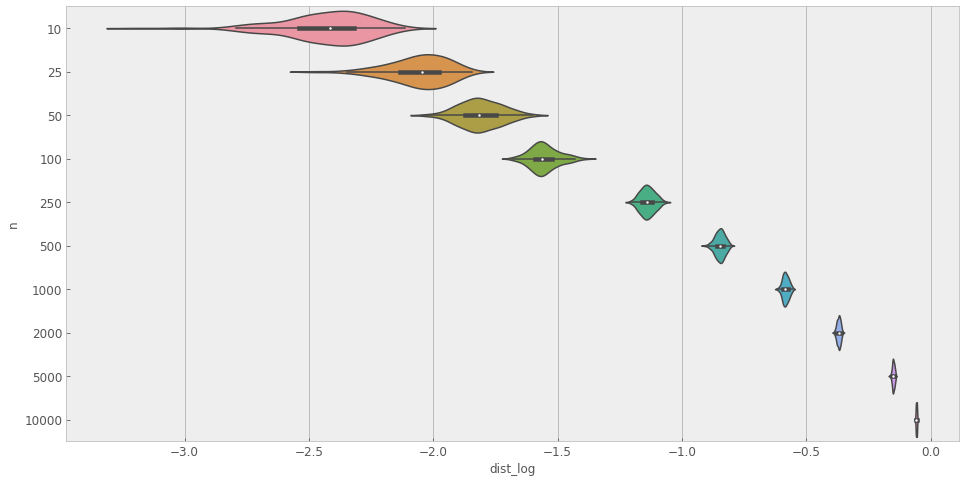

In [17]:
plt.figure(figsize=(16, 8))
sns.violinplot(data=test_df, x='dist_log', y='n', orient='h', scale='width')

## Create genomes

In [18]:
N_VALS = [10000, 1000, 200, 20]
DEPTH = len(N_VALS)
LEVEL_NAMES = list(ascii_uppercase[:DEPTH])

In [19]:
CHILD_COUNTS = [(5, 6), (3, 7), (3, 7), (2, 20)]

all_arrs = {(): base_arr}
keys_by_level = [[()]]

np.random.seed(0)

for l in range(DEPTH):
    keys_by_level.append([])
    
    for parent_key in keys_by_level[l]:
        n_children = np.random.randint(*CHILD_COUNTS[l])
        muts = make_mutations(all_arrs[parent_key], n_children, N_VALS[l])
        
        for i, mut in enumerate(muts):
            key = (*parent_key, i)
            keys_by_level[-1].append(key)
            all_arrs[key] = mut

In [20]:
all_seqs = {k: array2seq(arr) for k, arr in all_arrs.items()}

In [21]:
leaf_keys = keys_by_level[-1]
leaf_seqs = [all_seqs[k] for k in leaf_keys]

lineages = pd.DataFrame.from_records(leaf_keys, columns=LEVEL_NAMES)

In [22]:
list(map(len, keys_by_level))

[1, 5, 23, 90, 878]

### Genome/taxon attributes

In [23]:
_rows = []
_index = []

for level, keys in enumerate(keys_by_level[:-1]):
    for key in keys:
        if key:
            name = '_'.join('%s%d' % (l, i + 1) for i, l in zip(key, LEVEL_NAMES))
        else:
            name = 'root'
        _rows.append((name, level))
        _index.append(key)

taxa_df = pd.DataFrame.from_records(_rows, columns=['name', 'level'], index=_index)
taxa_df['parent'] = [taxa_df['name'][key[:-1]] if key else None for key in taxa_df.index]

n_taxa = taxa_df.shape[0]

In [24]:
genome_keys = keys_by_level[-1]
genome_tax_keys = []
_rows = []

for key in keys_by_level[-1]:
    taxon = taxa_df.at[key[:-1], 'name']
    name = '%s_%d' % (taxon, key[-1] + 1)
    strkey = 'midas/%s/%s' % (DBNAME, name)
    _rows.append((strkey, name, taxon))
    genome_tax_keys.append(key[:-1])
    
genomes_df = pd.DataFrame.from_records(_rows, columns=['key', 'name', 'taxon'])
genomes_df.index.name = 'index'

n_genomes = genomes_df.shape[0]

## Pairwise distances

In [25]:
ref_sigs = [vec_to_coords(find_kmers(kspec, seq)) for seq in leaf_seqs]

In [26]:
dmat = pw_dists(ref_sigs)

In [27]:
# Check there are no identical signatures
assert np.all(squareform(dmat) > 0)

### Inspect

In [28]:
dists_norm = LogNorm(vmin=np.min(squareform(dmat)), vmax=1.)

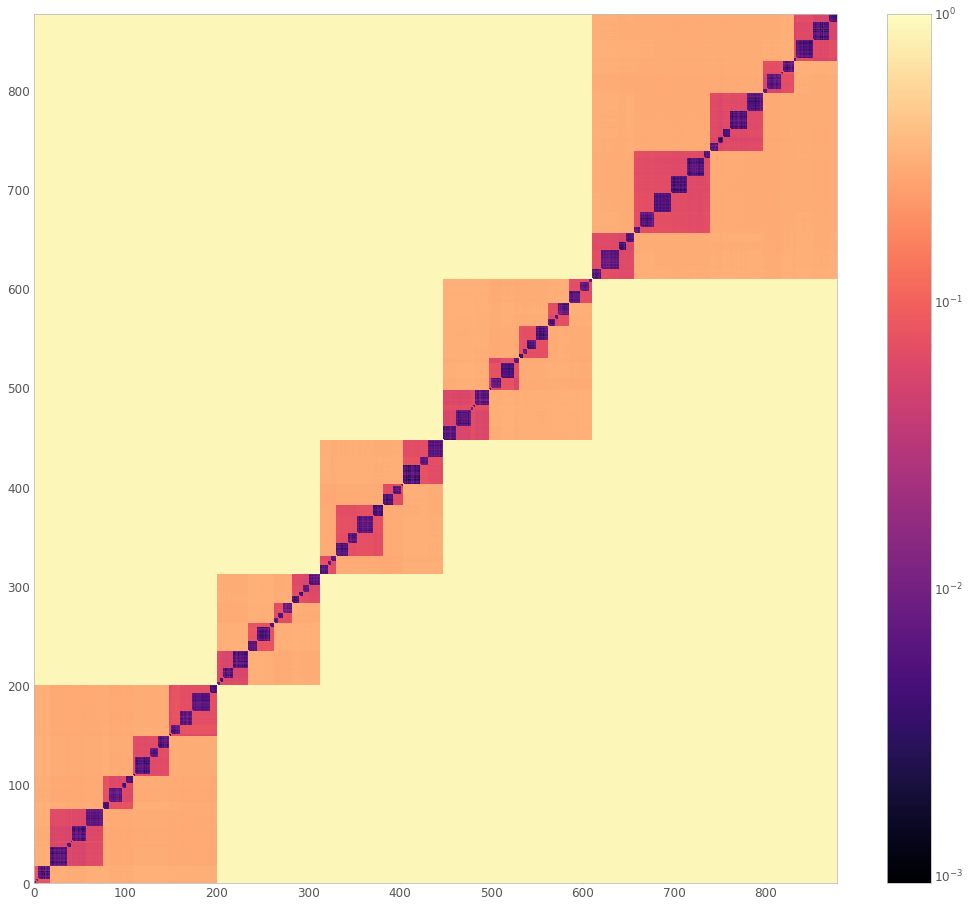

In [29]:
plt.figure(figsize=(18, 16))
plt.pcolor(dmat, norm=dists_norm)
plt.colorbar()

### Grouped min/max distances

In [30]:
dists_grouped_min = []
dists_grouped_max = []

for level in range(1, DEPTH):
    gb = lineages.groupby(LEVEL_NAMES[:level])
    level_indices = [df.index.values for _, df in gb]
    n = len(level_indices)
    
    minvals = np.full((n, n), -1.)
    maxvals = minvals.copy()
    
    for i in range(n):
        ii = level_indices[i]
        for j in range(i + 1):
            jj = level_indices[j]
            m = dmat[np.ix_(ii, jj)]
            minvals[i, j] = minvals[j, i] = np.min(m)
            maxvals[i, j] = maxvals[j, i] = np.max(m)
            
    dists_grouped_min.append(minvals)
    dists_grouped_max.append(maxvals)
    
# Level 0
dists_grouped_min.insert(0, np.zeros((1, 1)))
dists_grouped_max.insert(0, dmat.max(keepdims=True))

In [31]:
diameters = list(map(np.diag, dists_grouped_max))

taxa_df['diameter'] = 0.
for keys, diams in zip(keys_by_level, diameters):
    taxa_df.loc[keys, 'diameter'] = diams

In [32]:
min_intra = [
    np.asarray([np.sort(dmin[i])[1] for i in range(dmin.shape[0])])
    for dmin in dists_grouped_min[1:]
]
min_intra.insert(0, np.zeros((1, 1)))

<AxesSubplot:xlabel='dist', ylabel='depth'>

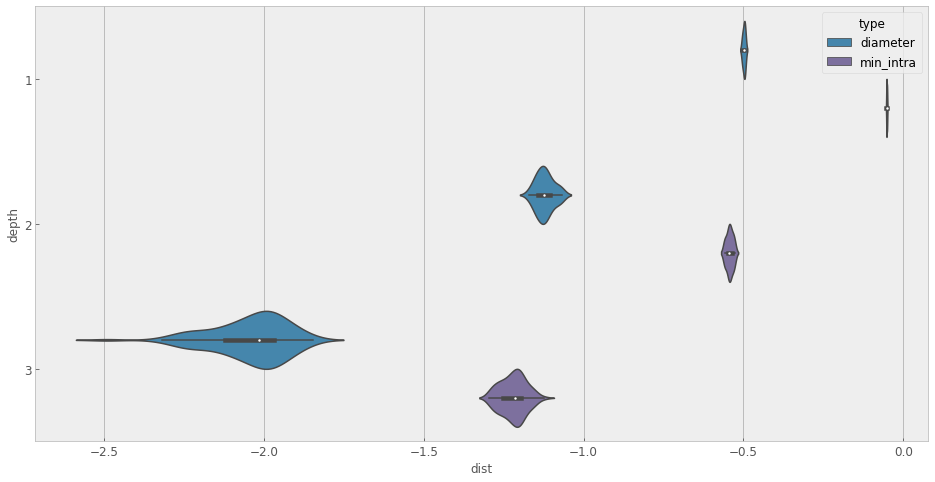

In [33]:
_dfs = [pd.DataFrame.from_dict(dict(depth=l, type='diameter', dist=np.log10(diameters[l]))) for l in range(1, DEPTH)]
_dfs.extend([pd.DataFrame.from_dict(dict(depth=l, type='min_intra', dist=np.log10(min_intra[l]))) for l in range(1, DEPTH)])

_df = pd.concat(_dfs)

plt.figure(figsize=(16, 8))
sns.violinplot(data=_df, x='dist', y='depth', hue='type', orient='h', scale='width')

### Check for overlaps

In [34]:
for mi, diams in zip(min_intra[1:], diameters[1:]):
    assert np.all(mi > diams)

## Create query sequences

In [35]:
def most_specific_key(keys):
    key = sorted(keys, key=len)[-1]
    
    # Check all others are ancestors
    for key2 in keys:
        assert key[:len(key2)] == key2
        
    return key

In [36]:
query_seqs = []
query_sigs = []
query_dists = np.zeros((n_taxa, n_genomes))

np.random.seed(0)

# Create one query sequence for each taxon
for i, query_key in enumerate(tqdm(taxa_df.index)):
    n = N_VALS[taxa_df.at[query_key, 'level']]
    
    # Multiple attempts, random mutation may not fit criteria
    for attempt in range(100):
        # Create mutation
        arr = all_arrs[query_key].copy()
        mutate_seq(arr, n)
        qseq = array2seq(arr)
        qsig = vec_to_coords(find_kmers(kspec, qseq))
        
        matched_keys = set()
        
        # Find distances and check for matches
        for j, gtkey in enumerate(genome_tax_keys):
            query_dists[i, j] = d = 1 - jaccard_coords(qsig, ref_sigs[j])
            
            for k in range(len(gtkey) + 1):
                akey = gtkey[:k]
                thresh = taxa_df.at[akey, 'diameter']
                if d < thresh:
                    matched_keys.add(akey)
                
        called_key = most_specific_key(matched_keys)
        if called_key == query_key:
            break  # Success
        
    else:
        raise RuntimeError('Maximum number of attempts exceeded')
        
    query_seqs.append(qseq)
    query_sigs.append(qsig)

100%|██████████| 119/119 [00:11<00:00, 10.06it/s]


In [37]:
queries_df = pd.DataFrame(dict(
    name=['query_' + tname for tname in taxa_df['name']],
    expected_taxon=taxa_df['name'].values,
))

### Add unclassifiable sequence

In [38]:
np.random.seed(1)
seq = array2seq(np.random.choice(NUC_BYTES, SEQLEN))
sig = vec_to_coords(find_kmers(kspec, seq))

In [39]:
# Check does not belong to root taxon
root_thresh = taxa_df.at[(), 'diameter']

for i, refsig in enumerate(ref_sigs):
    assert 1 - jaccard_coords(sig, refsig) > root_thresh

In [40]:
query_seqs.append(seq)
query_sigs.append(sig)

queries_df = queries_df.append(dict(name='query_unclassifiable', expected_taxon=None), ignore_index=True)

## Create database

### Initialize

In [41]:
dbfile = outdir / (DBNAME + '.db')
if dbfile.is_file():
    dbfile.unlink()

In [42]:
engine = create_engine('sqlite:///%s' % dbfile)
Session = sessionmaker(engine)

In [43]:
init_db(engine)

In [44]:
session = Session()

### Genome set

In [45]:
genome_set = ReferenceGenomeSet(
    key='midas/test/' + DBNAME,
    version='1.0',
    name=DBNAME,
    description='Database containing artificial genomes, to be used for end-to-end testing',
    extra=dict(
        date_created=DATESTR_LONG,
    ),
)

session.add(genome_set)

### Taxa

In [46]:
TAXON_RANKS = ['genus', 'species', 'subspecies']

In [47]:
taxa = dict()

for level, keys in enumerate(keys_by_level[:-1]):
    for key in keys:
        taxon = Taxon(
            name=taxa_df.at[key, 'name'],
            rank=TAXON_RANKS[level-1] if level > 0 else None,
            parent=taxa[key[:-1]] if key else None,
            reference_set=genome_set,
            distance_threshold=taxa_df.at[key, 'diameter'],
            report=True,
        )
        
        taxa[key] = taxon
        session.add(taxon)

### Genomes

In [48]:
genomes = []

for i, key in enumerate(keys_by_level[-1]):
    name = genomes_df.loc[i, 'name']
    gkey = 'midas/%s/%s' % (DBNAME, name)
    genome = Genome(key=gkey, version='1.0', description=name)
    
    a = AnnotatedGenome(
        reference_set=genome_set,
        genome=genome,
        primary_taxon=taxa[key[:-1]],
    )
    
    session.add(genome)
    session.add(a)
    genomes.append(genome)

### Finish

In [49]:
session.commit()

## Save data

### Tables

In [50]:
taxa_df.to_csv(tmpdir / 'taxa.csv', index=False)
genomes_df.to_csv(tmpdir / 'genomes.csv')
queries_df.to_csv(tmpdir / 'queries.csv', index=False)

### Genome sequences

In [51]:
ref_seqs_dir = tmpdir / 'reference_sequences'
ref_seqs_dir.mkdir(exist_ok=True)

for i, key in enumerate(genome_keys):
    seq = all_seqs[key]
    name = genomes_df.loc[i, 'name']
    id_ = genomes_df.loc[i, 'key']
    
    record = SeqRecord(seq, id=id_)
    SeqIO.write(record, ref_seqs_dir / (name + '.fa'), 'fasta')

In [52]:
for keys in keys_by_level[:-1]:
    for key in keys:
        seq = all_seqs[key]
        name = taxa_df['name'][key]

        record = SeqRecord(seq, id=name)
        SeqIO.write(record, ref_seqs_dir / (name + '.fa'), 'fasta')

In [53]:
query_seqs_dir = tmpdir / 'query_sequences'
query_seqs_dir.mkdir(exist_ok=True)

for i, seq in enumerate(query_seqs):
    name = queries_df.loc[i, 'name']
    
    record = SeqRecord(seq, id=name)
    SeqIO.write(record, query_seqs_dir / (name + '.fa'), 'fasta')

### Signatures

In [54]:
sigsfile = outdir / ('%s.midas-signatures' % DBNAME)

_meta = dict(
    id=genome_set.key,
    version='1.0',
    name=DBNAME,
    date_created=DATESTR_LONG,
    kmerspec=kspec.to_json(),
    description='Signatures for artificial genomes in %s database' % DBNAME,
)

with open(sigsfile, 'wb') as f:
    SignatureFile.write(
        f,
        ref_sigs,
        dtype=kspec.coords_dtype,
        ids=genomes_df['key'],
        metadata=_meta,
    )

In [55]:
!gzip {sigsfile}